# Итоговый проект "Банки — Анализ оттока клиентов"

### Задача**:**

Проанализируйте клиентов регионального банка и выделите сегменты клиентов, которые склонны уходить из банка.

- Проведите исследовательский анализ данных,
- Выделите портреты клиентов, которые склонны уходить из банка,
- Сформулируйте и проверьте статистические гипотезы.

    *Проверьте гипотезу различия дохода между теми клиентами, которые ушли и теми, которые остались.*

    *Сформулируйте и проверьте статистическую гипотезу относительно представленных данных*


(задачи выше сформулированы предварительно, окончательная постановка задачи произойдёт на вводной встрече)

### Описание датасетов

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

Колонки:

- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `Objects` — количество объектов в собственности,
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `Loyalty` — активный клиент,
- `estimated_salary` — заработная плата клиента,
- `Churn` — ушёл или нет.

По итогам исследования подготовьте презентацию. Для создания презентации используйте любой удобный инструмент, но отправить презентацию нужно **обязательно** в формате **pdf,** прикрепив ссылку на файл в основном проекте.

In [203]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.stats.weightstats
from scipy import stats as st
import numpy as np
import warnings
warnings.filterwarnings("ignore")

## Шаг 1. Загрузка данных и подготовка к исследованию

In [204]:
server_path = 'datasets/'
local_path = '/datasets/'

files = ['bank_dataset.csv', 'bank_scrooge.csv']

datasets = []

for file in files:
    try:
        datasets.append(pd.read_csv(server_path + file))
    except FileNotFoundError:
        datasets.append(pd.read_csv(local_path + file))

df_old = datasets[0]

path = "https://drive.google.com/uc?export=download&id=1-U61mhTz_N1ARjy2XSAZ7IlQqGjeqP0F"
df_new = datasets[1]

In [205]:
df = df_new
df.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34,5,174.00,1,1,0,67353.16,1


In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            10000 non-null  int64  
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 937.6+ KB


Вывод: из данных видно, что есть пропуски в столбце: balance. Столбцы приведены к правильным типам данных.

## Шаг 2. Подготовка данных (анализ пропусков) и их кодирование

### 2.1 Привести название столбцов к строчному регистру

In [207]:
df.columns = [i.lower() for i in df.columns]
df.head()

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,183012,850.0,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34,5,174.00,1,1,0,67353.16,1


### 2.2 Проверить на пропуски данных и решить что с пропусками делать

In [208]:
df['balance'].head()

0      59214.82
1     850594.33
2           NaN
3    1524746.26
4        174.00
Name: balance, dtype: float64

In [209]:
len(df[df['balance'].isna()])

2295

In [210]:
len(df[df['balance'].isna()])/len(df)

0.2295

Вывод: из полученных данных видим, что пропуски в столбце составляют 23%

In [211]:
df[df['balance'].isna() == True].head(10)

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
2,120722,892.0,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0
9,133130,906.0,Ярославль,Ж,67,0,NaN,1,0,1,238055.53,0
10,148929,927.0,Ростов,М,52,0,NaN,1,1,1,196820.07,0
11,172184,921.0,Ростов,М,41,0,NaN,1,1,1,217469.48,0
19,127034,922.0,Рыбинск,Ж,53,0,NaN,1,0,0,147094.82,0
21,177415,896.0,Рыбинск,Ж,47,0,NaN,1,0,0,225060.35,0
30,155730,946.0,Ярославль,Ж,47,0,NaN,2,1,1,660015.85,0
34,205226,944.0,Ярославль,М,35,0,NaN,2,1,1,239843.39,0
39,173175,924.0,Рыбинск,Ж,51,0,NaN,1,1,1,248844.47,0
43,228585,956.0,Ростов,М,41,0,NaN,1,1,0,115117.10,0


In [212]:
len(df[(df['balance'].isna() == True) & (df['churn'] == 1)])

13

In [213]:
len(df[(df['balance'].isna() == True) & (df['churn'] == 0)])

2282

In [214]:
len(df[df['balance'] == 0])

2

In [215]:
len(df[(df['balance'].isna() == True) & (df['credit_card'] == 1)])

1872

In [216]:
len(df[(df['balance'].isna() == True) & (df['credit_card'] == 0)])

423

In [217]:
len(df[(df['balance'].isna() == True) & (df['credit_card'] == 0)])/ len(df)

0.0423

Вывод: из данных видно, что почти все клиенты с пропусками остаются клиентами банка (только 13 человек ушли). Стоит отметить, что если посмотреть кол-во клиентов со значением на балансе 0, то можно увидеть, что таких всего 2. Можно предположить что пропуски вызваны тем, что клиненты не имеют средств на счете (возможно даже не пополняли), такое может быть если допустим карты раздавалить и оформлялись на клиентов качетсве промоакции. Клиентов с кредитнами картами оказалось подовляющее большинство из данной когорты. Пропуски клиентов без кредитных карт составляют всего 4%. Данные пропуски относятся к группе MNAR. Значение NaN относиться к типу float и можно не менять данное значение на 0.

### 2.3 добавить столбец наличие заработной карты (если зарплата больше 0, то заработная карта есть, иначе - нет)

In [218]:
df[df['est_salary'] > 0].head()

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,183012,850.0,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34,5,174.00,1,1,0,67353.16,1


In [219]:
len(df[df['est_salary'] > 0])

10000

Вывод: на основе полученных данных видно, что у всех в бд указана зарплата, скорее всего тут указана зарплата на основании информации клиентов или банка о их зарплата, не зависимо является клиент пользователем зарплаьного проекта в данном банке. На основе данным нельзя определить принадлежность клиента к зарплатному проекту в банке.

## Шаг 3. Исследовательский анализ данных (распределения, в т.ч. в разрезе оттока; портреты клиентов и их сравнение; корреляционный анализ)

### 3.1 Распределения, в т.ч. в разрезе оттока; портреты клиентов и их сравнение

проверить как влияет Возраст/баллы кредитного скоринга/заработная плата клиента на: кол-во объектов недвижимости, баланс счете, кол-во продуктов которыми пользуется клиент, наличие кредитной карты

In [220]:
df.corr()

,userid,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
userid,1.000000,0.009804,0.017890,0.004599,0.006133,-0.005683,0.005674,-0.031029,-0.000369,-0.012398
score,0.009804,1.000000,-0.012164,0.064126,0.235812,-0.004981,-0.094732,-0.031179,0.163866,0.106129
age,0.017890,-0.012164,1.000000,0.032934,0.071599,0.031810,-0.131441,-0.004164,-0.043305,-0.055798
equity,0.004599,0.064126,0.032934,1.000000,0.164126,0.430203,-0.167506,-0.001970,-0.171974,0.270672
balance,0.006133,0.235812,0.071599,0.164126,1.000000,0.073024,-0.059253,0.025004,0.339622,0.085442
products,-0.005683,-0.004981,0.031810,0.430203,0.073024,1.000000,-0.256392,0.040071,-0.119738,0.297110
credit_card,0.005674,-0.094732,-0.131441,-0.167506,-0.059253,-0.256392,1.000000,-0.033445,0.035556,-0.131491
last_activity,-0.031029,-0.031179,-0.004164,-0.001970,0.025004,0.040071,-0.033445,1.000000,0.003039,0.169190
est_salary,-0.000369,0.163866,-0.043305,-0.171974,0.339622,-0.119738,0.035556,0.003039,1.000000,0.001128
churn,-0.012398,0.106129,-0.055798,0.270672,0.085442,0.297110,-0.131491,0.169190,0.001128,1.000000


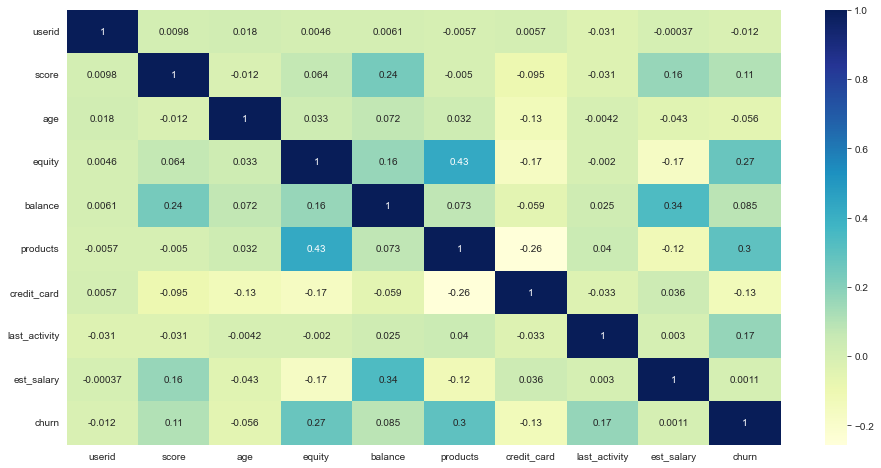

In [221]:
plt.figure(figsize=(16, 8))
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)
plt.show()

Вывод: из полученных данных видно, что взаимосвясь присутвует только в:
- кол-во продуктов и кол-во объектов недвижимости
- кол-во кредитного скоринга и уровнем дохода

In [222]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
model = LogisticRegression()
df_1 = df.fillna(0).copy()
X = df_1.drop(['churn', 'city', 'gender'], axis = 1)
y = df_1['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=0)

model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

from sklearn import metrics
prediction_test = model.predict(X_test)
print (metrics.accuracy_score(y_test, prediction_test))

weights = pd.Series(model.coef_[0],
                    index=X.columns.values)
weights.sort_values(ascending = False)

0.815


equity           2.013866e-05
products         1.088969e-05
last_activity    4.418583e-06
balance          3.584051e-07
est_salary      -1.194776e-06
credit_card     -3.730913e-06
userid          -6.798376e-06
age             -1.081282e-04
score           -4.663021e-04
dtype: float64

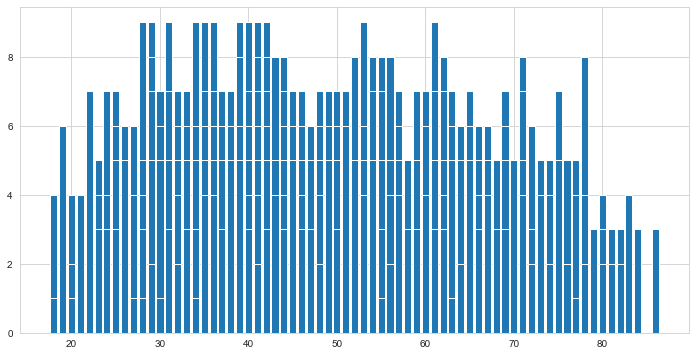

In [225]:
fig, ax = plt.subplots()
ax.bar(df['age'], df['equity'])
fig.set_figwidth(12)
fig.set_figheight(6)

plt.show()

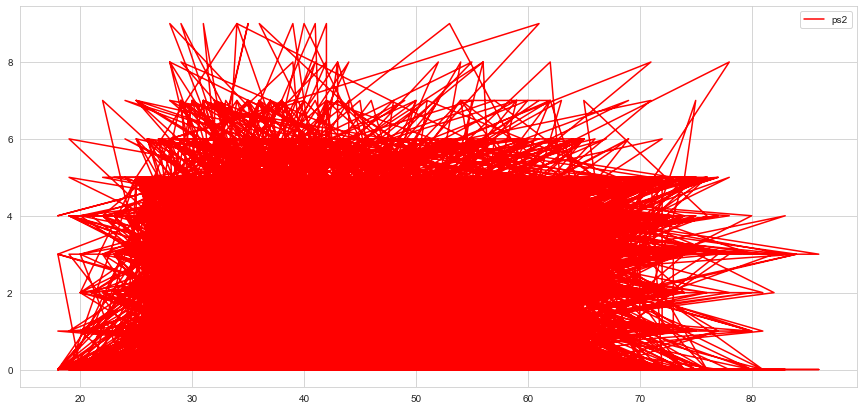

In [226]:
plt.figure(figsize=(15,7))
plt.plot(df['age'], df['equity'], color='r', label='ps2')

plt.legend()
plt.show()